## Bibliotecas

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rc = {"font.family": "serif",  # fonte serifada
      "mathtext.fontset": "cm",  # texto matemático em LaTeX
      "font.size": 14,  # Usar tamanho 12 ou 14
      "axes.axisbelow": True,  # grid abaixo dos dados
      "axes.grid": False,  # sem grid por padrão

      "text.usetex": True,  # latex em toda a figura
      }

%matplotlib inline

plt.rcParams.update(rc)


# GA

## O gene

O gene de cada indivíduo é uma **cidade**. Em outras palavras são as coordenadas $G = (x,y)$.

 A distância de cada cidade pode ser calculada pela distância euclidiana (desde que seja escolhido um dataset com essas características):

$$ d = \sqrt{(x_b - x_a)^2+(y_b-y_a)^2}$$

In [28]:
class Gene:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distancia(self, cidade):
        return np.sqrt((self.x - cidade.x)**2 + (self.y - cidade.y)**2)


## O indivíduo

O indivíduo é uma rota. A rota é a coleção de cidades que partem de uma cidade $C_i$, percorrem todo o caminho até $C_n$ do conjunto de $n$ cidades e retorna para a cidade $C_i$.


In [29]:
def criar_rota(lista_cidades):
    # TODO renomear pra criar indivíduo?
    rota = list(np.random.choice(lista_cidades, len(
        list(lista_cidades)), replace=False))
    # A última viagem é da última cidade para a cidade inicial
    rota.append(rota[0])
    return rota


## A população

É a coleção de indivíduos. Essa população é gerada de forma aleatória com base na lista de cidadades.

In [30]:

def populacao_inicial(tam, lista_cidades):
    return [criar_rota(lista_cidades) for _ in range(tam)]


## Fitness

O fitness é a forma de avaliar o indivíduo/população. No caso do TSP, pode-se utilizar como fitness o inverso da distância percorrida. Assim, quanto maior o fitness, menor é a distância percorrida (por consequência, melhor o resultado), e assim, fica fácil de interpretar os resultados.

$$ f = \frac{1}{d} =  \frac{1}{\sqrt{(x_b - x_a)^2+(y_b-y_a)^2}}$$

É importante considerar que a distância deve considerar a volta à primeira cidade.

In [31]:
class Fitness:
    def __init__(self, rota):
        self.rota = rota
        self.distancia = 0
        self.fitness = 0.0

    def distancia_total(self):
        if self.distancia == 0:
            distancia_total = 0

            # Calcula a distância da primeira cidade até a penúltima
            for i in range(len(self.rota) - 1):
                origem = self.rota[i]
                destino = self.rota[i + 1]
                distancia_total += origem.distancia(destino)

            # Calcula a distância da última cidade até a primeira
            distancia_total += self.rota[-1].distancia(self.rota[0])
            self.distancia = distancia_total

        return self.distancia

    def calcula_fitness(self):
        if self.fitness == 0:
            self.fitness = 1/(self.distancia_total())

        return self.fitness


## Cruzamento

O cruzamento é o processo de juntar dois indivíduos, combinar seus atributos e gerar um novo indivíduo. Como os indivíduos pais são indivíduos da população, eles podem ser levados para as próximas gerações.

O cruzamento realizado é o cruzamento ordenado.

In [32]:
def cruzamento(p1, p2):
    mascara_p1 = []
    mascara_p2 = []
    
    geneA = int(np.random.random() * len(p1))
    geneB = int(np.random.random() * len(p1))
    
    inicio = min(geneA, geneB)
    fim = max(geneA, geneB)

    for i in range(inicio, fim):
        mascara_p1.append(p1[i])
        
    mascara_p2 = [i for i in p2 if i not in mascara_p1]

    filho = mascara_p2[:inicio] + mascara_p1 + mascara_p2[inicio:]

    return filho

In [33]:
def seleciona_pais(populacao, melhor_populacao):
    pais = []
    for i in range(len(melhor_populacao)):
        indices = melhor_populacao[i]
        pais.append(populacao[indices])
    return pais


In [34]:
import random

def cruza_populacao(pais, tam_elite):
    filhos = []
    tam_cruzamento = len(pais) - tam_elite
    populacao = random.sample(pais, len(pais))

    for i in range(tam_elite):
        filhos.append(pais[i])

    for i in range(tam_cruzamento):
        filho = cruzamento(populacao[i], populacao[len(pais)-i-1])
        filhos.append(filho)
    return filhos


## Mutação

Introdução de variabilidade genética nos indivíduos da população. A mutação é feita a de troca. De forma simples, dois genes são trocados de lugar aleatoriamente.

In [35]:
def mutacao(mutado, taxa_mutacao):

    for i in range(len(mutado)):
        if(np.random.random() < taxa_mutacao):
            outro = int(np.random.random() * len(mutado))
            
            # troca(a,b)
            mutado[i], mutado[outro] = mutado[outro], mutado[i]
            
    return mutado


In [36]:
def muta_populacao(populacao, taxa_mutacao):
    populacao_mutada = []

    for i in range(len(populacao)):
        mutado = mutacao(populacao[i], taxa_mutacao)
        populacao_mutada.append(mutado)
    return populacao_mutada


## Seleção

A seleção (até agora) está sendo feita por roleta. Não é a melhor forma de se implementar mas é a mais fácil :/

In [37]:
import operator # apenas para usar um inteiro como indexador do dicionário ao invés da chave

def avalia_populacao(populacao):
    fitnessDict = {}
    for i in range(len(populacao)):
        fitnessDict[i] = Fitness(populacao[i]).calcula_fitness()

    # retorna o dicionário com chave e valor do fitness, ordenado pelo maior valor de fitness.
    return sorted(fitnessDict.items(), key=operator.itemgetter(1), reverse=True)


In [38]:
def selecao(populacao_rankeada, tam_elite):
    selecao = []

    # dá pra indexar esse negócio sem pandas mas vove
    df = pd.DataFrame(np.array(populacao_rankeada),
                      columns=["Indice", "Fitness"])

    df['fitness_acumulado'] = df['Fitness'].cumsum()
    df['fitness_normalizado'] = 100*df['fitness_acumulado']/df['Fitness'].sum()

    # Seleciona a elite
    for i in range(tam_elite):
        selecao.append(populacao_rankeada[i][0])

    # Roleta pro resto
    for i in range(len(populacao_rankeada) - tam_elite):
        chance = 100*np.random.random()
        for i in range(len(populacao_rankeada)):
            if chance <= df.iat[i, 3]:
                selecao.append(populacao_rankeada[i][0])
                break
    return selecao


# Próxima geração

Após o cruzamento e a mutação, são geradas novas populações, que em tese, serão melhores que a sua geração anterior.

In [39]:
def prox_geracao(geracao, tam_elite, taxa_mutacao):
    populacao_rankeada = avalia_populacao(geracao)
    selecionados = selecao(populacao_rankeada, tam_elite)
    pais = seleciona_pais(geracao, selecionados)
    filhos = cruza_populacao(pais, tam_elite)
    prox_geracao = muta_populacao(filhos, taxa_mutacao)
    return prox_geracao


In [40]:
def GA(cidades, tam_populacao, tam_elite, taxa_mutacao, n_geracoes, retorna_distancias=False):
    pop = populacao_inicial(tam_populacao, cidades)

    distancias_melhor = []
    distancias_pior = []
    for _ in range(n_geracoes):
        pop = prox_geracao(pop, tam_elite, taxa_mutacao)
        if retorna_distancias:
            distancias_melhor.append(1 / avalia_populacao(pop)[0][1])
            distancias_pior.append(1 / avalia_populacao(pop)[-1][1])

    indice_melhor_individuo = avalia_populacao(pop)[0][0]
    return pop[indice_melhor_individuo], distancias_melhor, distancias_pior


# Visualizando os resultados

## Leitura dos dados

In [41]:
def le_tsp(arquivo):
    tsp = pd.read_csv(arquivo, sep='\s', index_col=None,
                      header=None, skipfooter=1, skiprows=6, engine='python')
    tsp.columns = ['cidade', 'x', 'y']

    return tsp


def le_tsp_resolvido(arquivo, tsp):
    tour = pd.read_csv(arquivo, sep='\s', index_col=None,
                       header=None, skipfooter=1, skiprows=5, engine='python')
    tour.columns = ['cidade']

    # Troca o valor da última cidade para o valor da primeira
    tour.iloc[-1, 0] = tour.iloc[0, 0]

    sol_otima = tsp.loc[tour['cidade'].values - 1, :]

    return sol_otima


In [42]:
tsp_st70 = le_tsp('./data/st70.tsp')
sol_tsp_st70 = le_tsp_resolvido('./data/st70.opt.tour', tsp=tsp_st70)

In [43]:
tsp_berlin = le_tsp('./data/berlin52.tsp')
sol_tsp_berlin = le_tsp_resolvido('./data/berlin52.opt.tour', tsp=tsp_berlin)

In [44]:
def roda(cidades_df, tam_pop, tam_elite, taxa_mut, geracoes, retorna_distancias):
    cidades = []

    for i in range(len(cidades_df)):
        cidades.append(Gene(x=cidades_df.iat[i, 1], y=cidades_df.iat[i, 2]))

    melhor_ind, evolucao, evol_pior = GA(cidades, tam_pop, tam_elite, taxa_mut,
                              geracoes, retorna_distancias=retorna_distancias)

    solucao = []
    for gene in melhor_ind:
        solucao.append((gene.x, gene.y))

    solucao.append((solucao[0][0], solucao[0][1]))

    return solucao, evolucao, evol_pior


In [45]:
if __name__ == '__main__':
    sol_st70, evol_st70, evol_st70_pior = roda(tsp_st70, 20, 5, 0.01, 5000, True)
    sol_berlin, evol_berlin, evol_berlin_pior = roda(tsp_berlin, 20, 5, 0.01, 5000, True)

In [46]:
def calcula_distancia_resultados(sol_otima=None, resultados=None):
    if sol_otima is not None:
        rota = sol_otima.iloc[:, 1:].to_numpy()
    elif resultados is not None:
        rota = resultados
    else: return
        

    r_x, r_y = list(zip(*rota))

    d_otima = 0
    for i in range(len(rota) - 1):
        d_otima += np.sqrt((r_x[i+1] - r_x[i])**2 + (r_y[i+1] - r_y[i])**2)
    return d_otima


In [47]:
d_o_berlin = calcula_distancia_resultados(sol_tsp_berlin)
d_o_st70 = calcula_distancia_resultados(sol_tsp_st70)

resultado_st70 = calcula_distancia_resultados(resultados=sol_st70)
resultado_berlin = calcula_distancia_resultados(resultados=sol_berlin)

In [55]:
print(resultado_st70,
      d_o_st70,
      resultado_berlin,
      d_o_berlin,)


1725.3005208015832 678.5974520966245 9469.45613361772 7528.178408383573


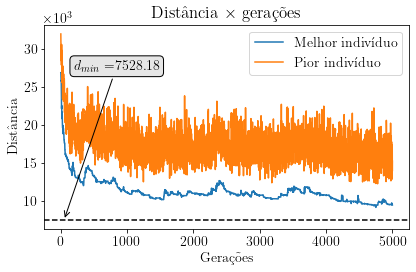

In [69]:
f, ax = plt.subplots(figsize=(6,4))

ax.plot(evol_berlin, label='Melhor indivíduo')
ax.plot(evol_berlin_pior, label= 'Pior indivíduo')

ax.axhline(y=d_o_berlin, linestyle='--', c='k')

ax.set_title(r'Distância $\times$ gerações')

ax.set(
    ylabel='Distância',
    xlabel='Gerações'
)

ax.annotate(
    text=r'$d_{min}=$' + f'{d_o_berlin:.2f}',
    xy=(50,d_o_berlin),
    xytext=(10, 150),
    textcoords='offset points',
    bbox=dict(boxstyle='round', fc='0.9'),
    arrowprops=dict(arrowstyle='->')
)

ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3), useMathText=True)

ax.legend()

f.tight_layout()
plt.show()

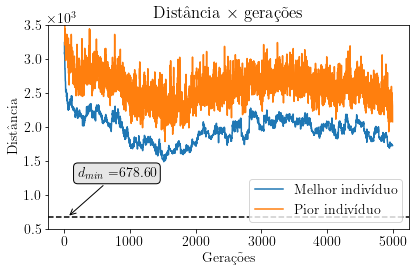

In [74]:
f, ax = plt.subplots(figsize=(6,4))

ax.plot(evol_st70, label='Melhor indivíduo')
ax.plot(evol_st70_pior, label='Pior indivíduo')
ax.axhline(y=d_o_st70, linestyle='--', c='k')

ax.set_title(r'Distância $\times$ gerações')

ax.set(
    ylabel='Distância',
    xlabel='Gerações',
    ylim=[500, 3500]
)

ax.annotate(
    text=r'$d_{min}=$' + f'{d_o_st70:.2f}',
    xy=(50,d_o_st70),
    xytext=(10, 40),
    textcoords='offset points',
    bbox=dict(boxstyle='round', fc='0.9'),
    arrowprops=dict(arrowstyle='->')
)

ax.legend(loc='lower right')

ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3), useMathText=True)

f.tight_layout()
plt.show()

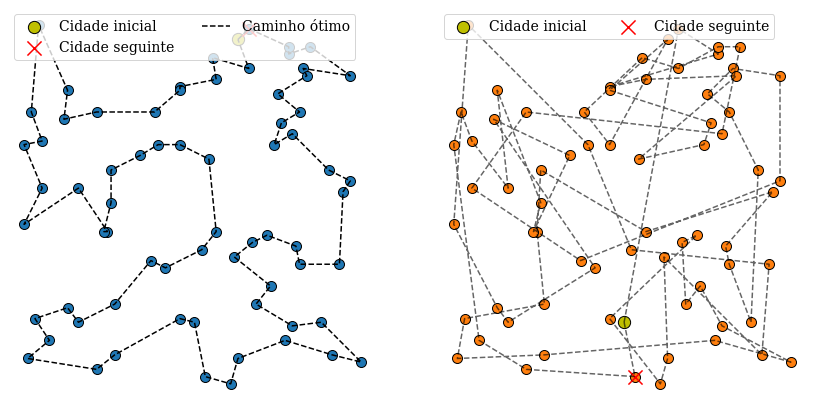

In [51]:

f, ax = plt.subplots(ncols=2, figsize=(12, 12))

ax[0].scatter(tsp_st70['x'], tsp_st70['y'], edgecolors='k', s=100,)

ax[0].scatter(sol_tsp_st70.iloc[0, 1], sol_tsp_st70.iloc[0, 2],
              edgecolors='k', c='y', s=150, label='Cidade inicial')
ax[0].scatter(sol_tsp_st70.iloc[1, 1], sol_tsp_st70.iloc[1, 2], c='r',
              s=200, label='Cidade seguinte', marker='x')
ax[0].plot(sol_tsp_st70['x'], sol_tsp_st70['y'], '--', c='k', label='Caminho ótimo')

sol_x, sol_y = list(zip(*sol_st70))

ax[1].scatter(tsp_st70['x'], tsp_st70['y'], edgecolors='k', s=100, c='C1')
ax[1].scatter(sol_x[0], sol_y[0],
              edgecolors='k', c='y', s=150, label='Cidade inicial')
ax[1].scatter(sol_x[1], sol_y[1], c='r', s=200,
              marker='x', label='Cidade seguinte')

ax[1].plot(sol_x, sol_y, '--', c='k', alpha=0.6)

for a in ax.flat:
    a.set(
        xticklabels=[],
        yticklabels=[],
    )
    a.legend(loc=2, ncol=2)
    a.axis('off')
    a.set_aspect('equal')
    
f.tight_layout()


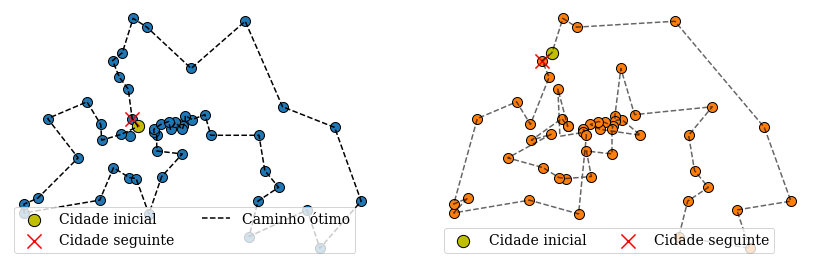

In [52]:

f, ax = plt.subplots(ncols=2, figsize=(12, 12))

ax[0].scatter(tsp_berlin['x'], tsp_berlin['y'], edgecolors='k', s=100,)

ax[0].scatter(sol_tsp_berlin.iloc[0, 1], sol_tsp_berlin.iloc[0, 2],
              edgecolors='k', c='y', s=150, label='Cidade inicial')
ax[0].scatter(sol_tsp_berlin.iloc[1, 1], sol_tsp_berlin.iloc[1, 2], c='r',
              s=200, label='Cidade seguinte', marker='x')
ax[0].plot(sol_tsp_berlin['x'], sol_tsp_berlin['y'], '--', c='k', label='Caminho ótimo')

sol_x, sol_y = list(zip(*sol_berlin))

ax[1].scatter(sol_tsp_berlin['x'], sol_tsp_berlin['y'], edgecolors='k', s=100, c='C1')
ax[1].scatter(sol_x[0], sol_y[0],
              edgecolors='k', c='y', s=150, label='Cidade inicial')
ax[1].scatter(sol_x[1], sol_y[1], c='r', s=200,
              marker='x', label='Cidade seguinte')

ax[1].plot(sol_x, sol_y, '--', c='k', alpha=0.6)

for a in ax.flat:
    a.set(
        xticklabels=[],
        yticklabels=[],
    )
    a.legend(loc='lower left', ncol=2)
    a.axis('off')
    a.set_aspect('equal')
    
f.tight_layout()


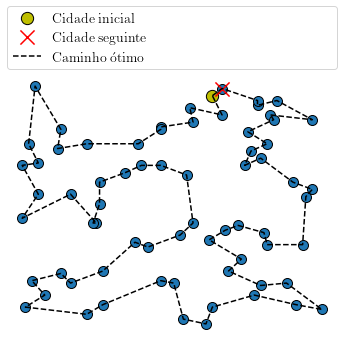

In [118]:
# repetindo os gráficos acima só pra salvar no relatório


f, ax = plt.subplots(figsize=(5,5))

ax.scatter(tsp_st70['x'], tsp_st70['y'], edgecolors='k', s=100,)

ax.scatter(sol_tsp_st70.iloc[0, 1], sol_tsp_st70.iloc[0, 2],
              edgecolors='k', c='y', s=150, label='Cidade inicial')
ax.scatter(sol_tsp_st70.iloc[1, 1], sol_tsp_st70.iloc[1, 2], c='r',
              s=200, label='Cidade seguinte', marker='x')
ax.plot(sol_tsp_st70['x'], sol_tsp_st70['y'], '--', c='k', label='Caminho ótimo')

ax.axis('off')
# ax.set_aspect('equal')

ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=1)

f.tight_layout()

f.savefig('./solucao_otima_st70.pdf')


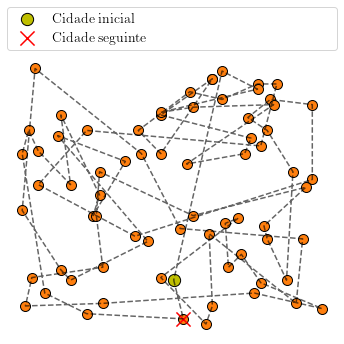

In [120]:
f, ax = plt.subplots(figsize=(5, 5))

sol_x, sol_y = list(zip(*sol_st70))


ax.scatter(sol_tsp_st70['x'], sol_tsp_st70['y'],
              edgecolors='k', s=100, c='C1')
ax.scatter(sol_x[0], sol_y[0],
              edgecolors='k', c='y', s=150, label='Cidade inicial')
ax.scatter(sol_x[1], sol_y[1], c='r', s=200,
              marker='x', label='Cidade seguinte')

ax.plot(sol_x, sol_y, '--', c='k', alpha=0.6)

ax.axis('off')

ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=1)

f.tight_layout()

f.savefig('./solucao_encontrada_st70.pdf')
